In [1]:
from chaotic_inventory_opt.control.classical import sSPolicy, BaseStockPolicy
from chaotic_inventory_opt.control.fcio import FCIOPolicy
from chaotic_inventory_opt.core.inventory_system import InventorySystem
from chaotic_inventory_opt.core.cost import CostModel
from chaotic_inventory_opt.evaluation.performance import PerformanceMetrics
from chaotic_inventory_opt.evaluation.stability import StabilityMetrics
from chaotic_inventory_opt.chaos.lyapunov import LyapunovExponentEstimator

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


c:\Users\SANTANU\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

cost_model = CostModel(holding_cost_per_unit=0.1,
                       stockout_cost_per_unit=5.0,
                       fixed_order_cost=1.0)




In [3]:
ssp = sSPolicy(reorder_point=10, order_up_to=30)
bs  = BaseStockPolicy(base_stock_level=30)


In [4]:
def simulate_policy(policy, demand_series):
    system = InventorySystem(initial_inventory=30)
    perf = PerformanceMetrics()
    stab = StabilityMetrics(LyapunovExponentEstimator())

    for d in demand_series:
        if hasattr(policy, "observe"):
            policy.observe(d)

        order_qty = policy.order(system.I)
        inv = system.step(d, order_qty)

        cost = cost_model.compute(inv, order_qty)
        perf.update(d, inv, cost)
        stab.update(inv)

    return perf.results(), stab.results()


In [5]:
import pandas as pd
import os
import numpy as np

def load_m5_demand(item_id, store_id):
    sales = pd.read_csv("sales_train_validation.csv")

    row = sales[
        (sales["item_id"] == item_id) &
        (sales["store_id"] == store_id)
    ]

    d_cols = [c for c in row.columns if c.startswith("d_")]
    return row[d_cols].values.flatten().astype(float)



In [6]:
demand = load_m5_demand("FOODS_3_090", "CA_1")

In [7]:
results_ssp, stab_ssp = simulate_policy(ssp, demand)
results_bs , stab_bs  = simulate_policy(bs,  demand)

print("Classical (s,S):", results_ssp, stab_ssp)
print("Base Stock:", results_bs, stab_bs)


Classical (s,S): {'total_cost': 424423.40000000095, 'service_level': 0.3371697208399173, 'stockout_events': 1396} {'inventory_variance': 509.4304, 'lyapunov_exponent': 2.123664029504204}
Base Stock: {'total_cost': 423871.5, 'service_level': 0.33808164901771187, 'stockout_events': 1396} {'inventory_variance': 509.4304, 'lyapunov_exponent': 2.123664029504204}


In [8]:
def fcio_objective(trial):
    fcio = FCIOPolicy(
        base_stock_level=30,
        reorder_point=10,
        alpha=trial.suggest_float("alpha", 0.1, 1.5),
        beta=trial.suggest_float("beta", 0.1, 1.5),
        scale_min=trial.suggest_float("scale_min", 0.5, 0.9),
        scale_max=trial.suggest_float("scale_max", 1.1, 1.6),
        rho=trial.suggest_float("rho", 0.4, 0.8),
        gamma=trial.suggest_float("gamma", 1.0, 2.0),
        k_cap=trial.suggest_float("k_cap", 0.4, 1.0),
        window=100,
    )

    results, _ = simulate_policy(fcio, demand)

    score = (
        results["total_cost"]
        + 5_000 * results["stockout_events"]
        + 100_000 * max(0, 0.95 - results["service_level"])
    )

    return score


In [9]:
study = optuna.create_study(direction="minimize")
study.optimize(fcio_objective, n_trials=100)

print("Best score:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


[I 2026-01-02 22:25:51,710] A new study created in memory with name: no-name-06fb32db-e549-409f-aeb7-76801aac1f7b
[I 2026-01-02 22:25:52,526] Trial 0 finished with value: 7313239.525988451 and parameters: {'alpha': 0.8496651866859277, 'beta': 1.35251865420886, 'scale_min': 0.8185159174173442, 'scale_max': 1.439701524550406, 'rho': 0.568788290892945, 'gamma': 1.0770167414224732, 'k_cap': 0.5654803767103851}. Best is trial 0 with value: 7313239.525988451.
[I 2026-01-02 22:25:53,281] Trial 1 finished with value: 2301370.7022382594 and parameters: {'alpha': 1.158823570360882, 'beta': 0.40705305815609905, 'scale_min': 0.6498737801217896, 'scale_max': 1.1956627925148793, 'rho': 0.7757125550113014, 'gamma': 1.23011562251939, 'k_cap': 0.764335960148852}. Best is trial 1 with value: 2301370.7022382594.
[I 2026-01-02 22:25:54,022] Trial 2 finished with value: 2528813.8594336784 and parameters: {'alpha': 0.8918413102473197, 'beta': 0.37713082051168734, 'scale_min': 0.7815979370086754, 'scale_max'

Best score: 129428.28280922965
Best params:
alpha: 0.5943028612496332
beta: 0.5237425340166263
scale_min: 0.6814938150884132
scale_max: 1.1780756374197088
rho: 0.7996234237273843
gamma: 1.809872753005622
k_cap: 0.7859545414397252


In [10]:
best = study.best_params

fcio_best = FCIOPolicy(
    base_stock_level=30,
    reorder_point=10,
    window=100,
    **best
)

results_fcio, stab_fcio = simulate_policy(fcio_best, demand)

print("FCIO:", results_fcio, stab_fcio)


FCIO: {'total_cost': 29428.282809229655, 'service_level': 0.987307534476567, 'stockout_events': 20} {'inventory_variance': 383.22314147574383, 'lyapunov_exponent': 1.7945072137158402}


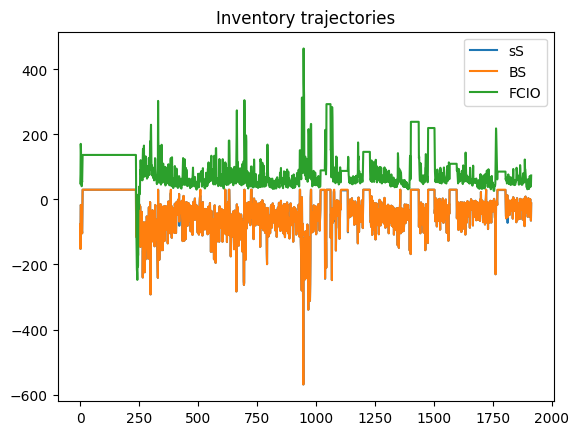

In [11]:
for policy, label in [(ssp, "sS"), (bs, "BS"), (fcio_best, "FCIO")]:
    system = InventorySystem(30)
    inv_hist = []

    for d in demand:
        if hasattr(policy, "observe"):
            policy.observe(d)
        inv_hist.append(system.step(d, policy.order(system.I)))

    plt.plot(inv_hist, label=label)

plt.legend()
plt.title("Inventory trajectories")
plt.show()
